In [331]:
import re
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup
import json
from pylab import *
import pandas as pd
from dogues_functions_2 import clean_article_name, plot_category_trends, fetch_pageview_count, normal_data, extract_clean_text, fetch_and_combine_pageview_data, scrape_wikipedia_sub_subheadings_with_links, fetch_pageview_count_dates, fetch_viewcount_df


# Loading the data from milestone 2 

In [332]:
#load data into df
df_fakecovidNews = pd.read_csv('./Data/covid-19_misinformation5.csv')

In [333]:

def getSubLinksFromIntro(website):
    link = "https://en.wikipedia.org/wiki/"+website

    #load online the html file 
    r = requests.get(link)
    soup = BeautifulSoup(r.text, 'html.parser')

    intro = soup.find_all('div', attrs={'class':'mw-content-ltr mw-parser-output'})[0].find_all('p')[2]
    #get the all the href
    links = intro.find_all('a', href=True)
    #make it into a list
    links = [link['href'] for link in links]

    return links


  
def existed(article, dateMin="2020-03-01"):
    #check if the first timestamp is less dateMin 
    if pd.Timestamp(article.iloc[0]['timestamp']) <= pd.Timestamp(dateMin):
        return True
    else:
        return False  


def getSubLinksFromIntroPablo(links):
    views = []
    for link in links:
        result = fetch_pageview_count("en", link)
        if(len(result) != 0):
            views.append(result)

    return views[0]



In [363]:
#make subplot of all the views of dfViewFinal
def plotAllInfos(topic, function):

    fig, axs = plt.subplots(len(topic.dfViewFinal)//3 + 1, 3, figsize=(15, len(topic.dfViewFinal)), sharex=True)
    for i in range(len(topic.dfViewFinal)):
        plt.xticks(rotation=45)
        axs[i//3, i%3].plot(topic.dfViewFinal[i]['timestamp'], function(topic.dfViewFinal[i]['views']))
        axs[i//3, i%3].set_title(topic.dfViewFinal[i]['article'].unique()[0])

        #axs[i].set_title(topic.dfViewFinal[i]['article'])
        #make rotation of x axis
        axs[i//3, i%3].set_ylabel('Views')
        axs[i//3, i%3].set_xlabel('Date')


    #make subplot of all the views of dfViewSubLinksFinal
    fig, axs = plt.subplots(len(topic.dfViewSubLinksFinal)//3+1, 3, figsize=(15, len(topic.dfViewSubLinksFinal)), sharex=True)
    for i in range(len(topic.dfViewSubLinksFinal)):
        plt.xticks(rotation=45)
        axs[i//3, i%3].plot(topic.dfViewSubLinksFinal[i]['timestamp'], function(topic.dfViewSubLinksFinal[i]['views']))
        axs[i//3, i%3].set_title(topic.dfViewSubLinksFinal[i]['article'].unique()[0])
        #axs[i].set_title(topic.dfViewFinal[i]['article'])
        #make rotation of x axis
        axs[i//3, i%3].set_ylabel('Views')
        axs[i//3, i%3].set_xlabel('Date')


def getViewsNormalizedTotal(topic, function):
    dftemp = topic.dfViewFinal.copy()

    columns = ["timestamp", "viewNormalized"]
    newdf = pd.DataFrame(columns=columns)

    for i in range(len(topic.dfViewFinal)):
        dftemp[i]["viewNormalized"] = function(topic.dfViewFinal[i]['views'])
        newdf = pd.concat([newdf, dftemp[i][["timestamp", "viewNormalized"]]], ignore_index=True)

    newdf = newdf.groupby("timestamp").sum()

    return newdf
    



def getInfoByArticles(df):
    columns = ["article", "views"]
    newdf = pd.DataFrame(columns=columns)

    for i in range(len(df)):
        newdf = pd.concat([newdf, df[i][["article", "views"]]], ignore_index=True)

    mean = newdf.groupby("article").mean()
    median = newdf.groupby("article").median()
    std = newdf.groupby("article").std()



    #rename the columns
    mean.columns = ["mean"]
    median.columns = ["median"]
    std.columns = ["std"]
    newdf = pd.concat([mean, median, std], axis=1)


    return newdf

 Functions for normalization of the data (ex relative increase ect ect)

In [360]:

def standarization(array):
    return (array - np.mean(array)) / np.std(array)

def minMax(array):
    return (array - np.min(array)) / (np.max(array) - np.min(array))

def nonefunction(array):
    return array

In [468]:
class wikiTopic:
    df = []

    links = []
    dfView = []
    dfViewFinal = []

    dfSubLinks = []
    dfViewSubLinks = []
    dfViewSubLinksFinal = []

    def __init__(self, df, index):
        self.df = df.iloc[index]

        self.extractLinksFromDf()
        self.getViews()

        #self.getSublinks()
        #self.getViewsSubLinks()

    def extractLinksFromDf(self):

        links = self.df.Links
        links = links.split(',')
        self.links = [re.sub(r'[\[\]\'\s]', '', link) for link in links]
        self.links = [re.sub(r'/wiki/', '', link) for link in self.links]
        self.links = [link for link in self.links if link != '']

    def getViews(self):
        #fetch view counts
        print(self.links)
        viewsdf = fetch_pageview_count("en", self.links)
        keys = list(viewsdf.keys())
        print(keys)
        #print(viewsdf)
        #make a list of df 
        for i in range(len(keys)):
            print(keys[i])
            print(viewsdf[keys[i]])
            self.dfView.append(viewsdf[keys[i]])

            if(existed(viewsdf[keys[i]])):
                self.dfViewFinal.append(viewsdf[keys[i]])
            
    

    def getSublinks(self):
        for i in range(len(self.links)):
            allSublinks = getSubLinksFromIntro(self.links[i])
            allSublinks = [re.sub(r'/wiki/', '', link) for link in allSublinks]
            #if the sublinks have "#cite_" remove them 
            allSublinks = [link for link in allSublinks if "#cite_" not in link]
            self.dfSubLinks.append(allSublinks)

    def getViewsSubLinks(self):
        #fetch view counts
        viewsdf = getSubLinksFromIntroPablo(self.dfSubLinks)
        keys = list(viewsdf.keys())
        #make a list of df 
        for i in range(len(keys)):
            if(existed(viewsdf[keys[i]])):
                self.dfViewSubLinksFinal.append(viewsdf[keys[i]])
            self.dfViewSubLinks.append(viewsdf[keys[i]])




In [469]:
topic = wikiTopic(df_fakecovidNews, 2)

['Gain-of-function_research', 'Angela_Rasmussen', 'Tucker_Carlson', 'Nicholas_Wade', 'Rand_Paul', 'Ralph_Baric', 'Francis_Collins', 'Chimeric_virus']
['Gain-of-function_research', 'Angela_Rasmussen', 'Tucker_Carlson', 'Nicholas_Wade', 'Rand_Paul', 'Ralph_Baric', 'Francis_Collins', 'Chimeric_virus']
Gain-of-function_research
          project                    article granularity  timestamp  \
0    en.wikipedia  Gain-of-function_research       daily 2021-01-16   
1    en.wikipedia  Gain-of-function_research       daily 2021-01-17   
2    en.wikipedia  Gain-of-function_research       daily 2021-01-18   
3    en.wikipedia  Gain-of-function_research       daily 2021-01-19   
4    en.wikipedia  Gain-of-function_research       daily 2021-01-20   
..            ...                        ...         ...        ...   
859  en.wikipedia  Gain-of-function_research       daily 2023-05-27   
860  en.wikipedia  Gain-of-function_research       daily 2023-05-28   
861  en.wikipedia  Gain-of-function

In [470]:
topic = wikiTopic(df_fakecovidNews, 3)

['Tedros_Adhanom_Ghebreyesus', 'Science_(journal)']
['Tedros_Adhanom_Ghebreyesus', 'Science_(journal)']
Tedros_Adhanom_Ghebreyesus
           project                     article granularity  timestamp  \
0     en.wikipedia  Tedros_Adhanom_Ghebreyesus       daily 2019-01-01   
1     en.wikipedia  Tedros_Adhanom_Ghebreyesus       daily 2019-01-02   
2     en.wikipedia  Tedros_Adhanom_Ghebreyesus       daily 2019-01-03   
3     en.wikipedia  Tedros_Adhanom_Ghebreyesus       daily 2019-01-04   
4     en.wikipedia  Tedros_Adhanom_Ghebreyesus       daily 2019-01-05   
...            ...                         ...         ...        ...   
1606  en.wikipedia  Tedros_Adhanom_Ghebreyesus       daily 2023-05-27   
1607  en.wikipedia  Tedros_Adhanom_Ghebreyesus       daily 2023-05-28   
1608  en.wikipedia  Tedros_Adhanom_Ghebreyesus       daily 2023-05-29   
1609  en.wikipedia  Tedros_Adhanom_Ghebreyesus       daily 2023-05-30   
1610  en.wikipedia  Tedros_Adhanom_Ghebreyesus       daily 2023-05

In [471]:
topic.dfView

[          project                    article granularity  timestamp  \
 0    en.wikipedia  Gain-of-function_research       daily 2021-01-16   
 1    en.wikipedia  Gain-of-function_research       daily 2021-01-17   
 2    en.wikipedia  Gain-of-function_research       daily 2021-01-18   
 3    en.wikipedia  Gain-of-function_research       daily 2021-01-19   
 4    en.wikipedia  Gain-of-function_research       daily 2021-01-20   
 ..            ...                        ...         ...        ...   
 859  en.wikipedia  Gain-of-function_research       daily 2023-05-27   
 860  en.wikipedia  Gain-of-function_research       daily 2023-05-28   
 861  en.wikipedia  Gain-of-function_research       daily 2023-05-29   
 862  en.wikipedia  Gain-of-function_research       daily 2023-05-30   
 863  en.wikipedia  Gain-of-function_research       daily 2023-05-31   
 
          access agent  views  
 0    all-access  user      1  
 1    all-access  user      2  
 2    all-access  user      6  
 3    

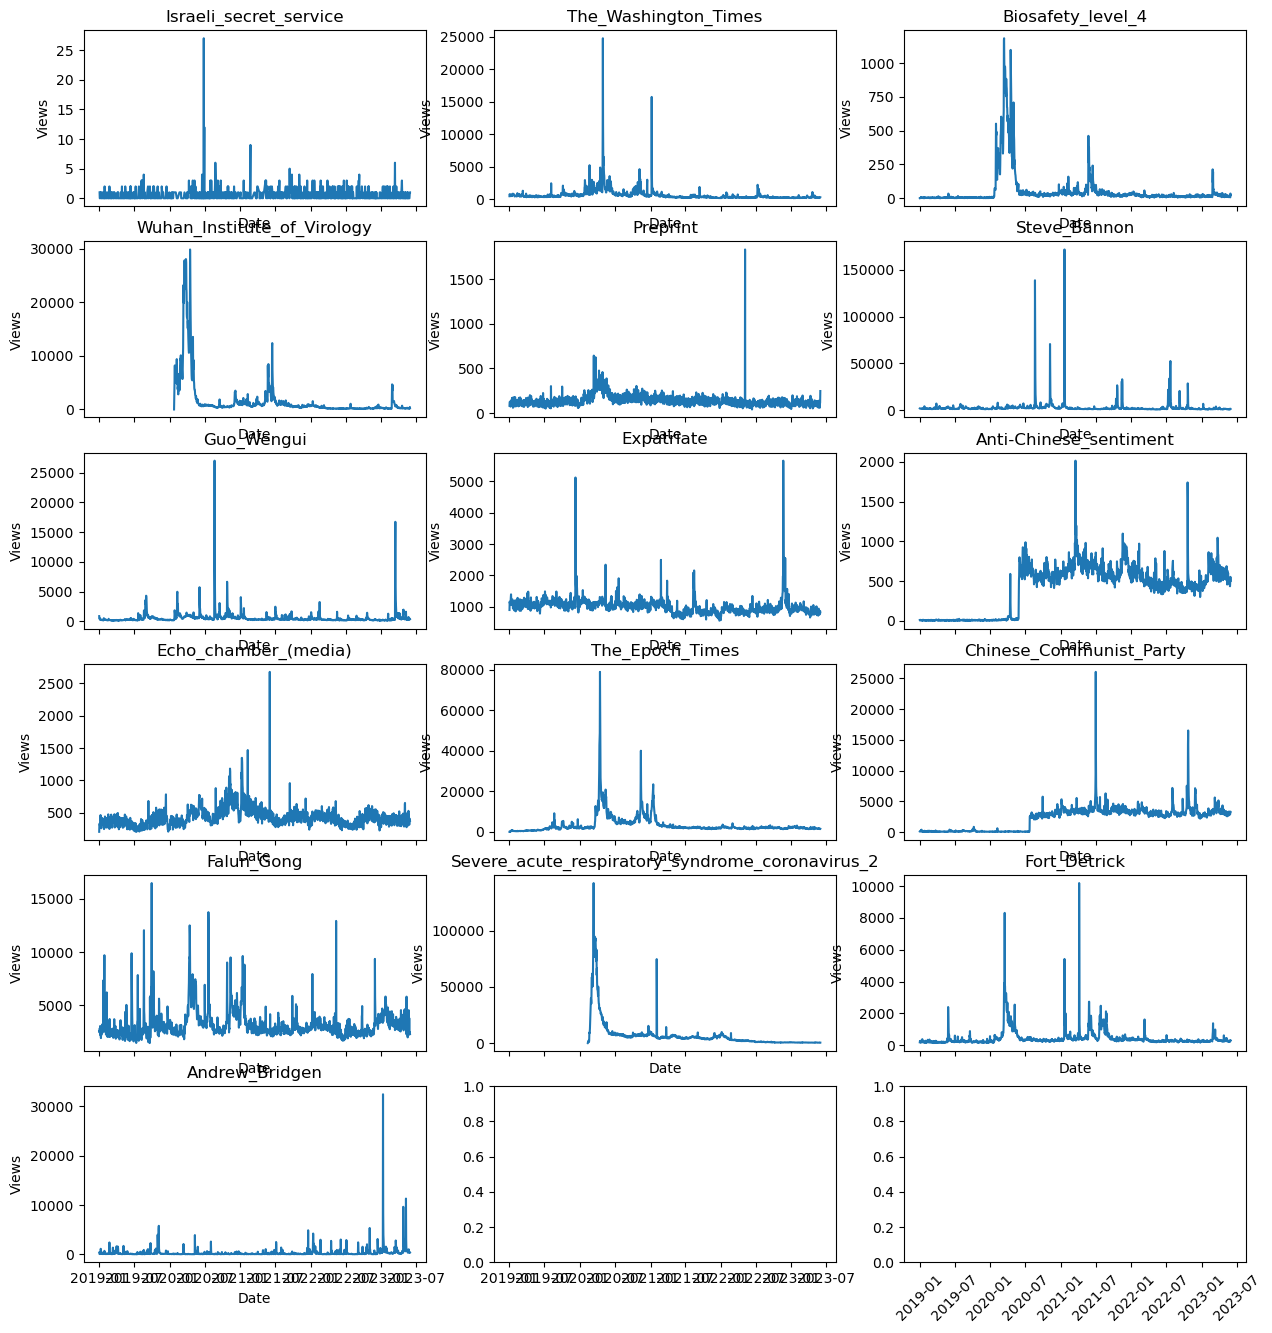

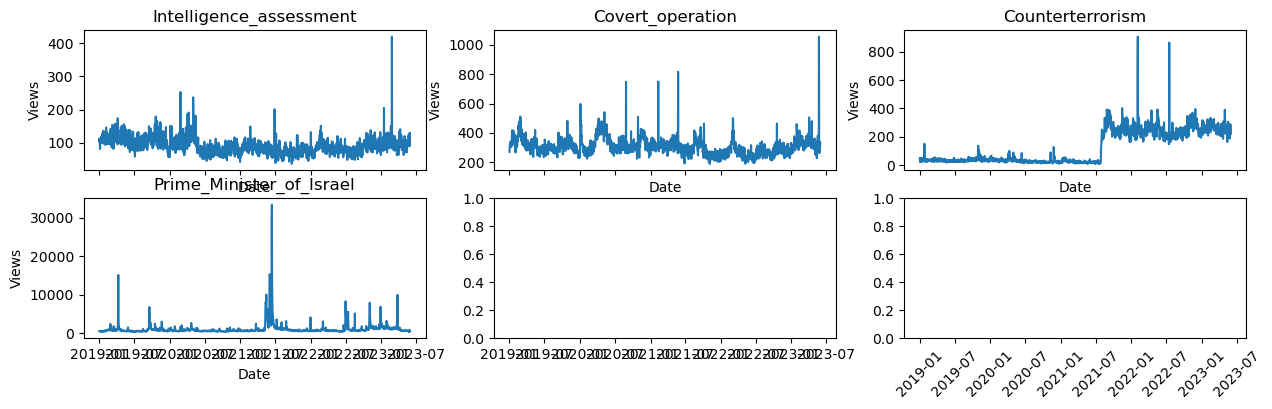

In [340]:
plotAllInfos(topic, nonefunction)

C:\Users\pablo\AppData\Local\Temp\ipykernel_8036\3824554915.py:9: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  newdf = pd.concat([newdf, dftemp[i][["timestamp", "viewNormalized"]]], ignore_index=True)


<Axes: xlabel='timestamp'>

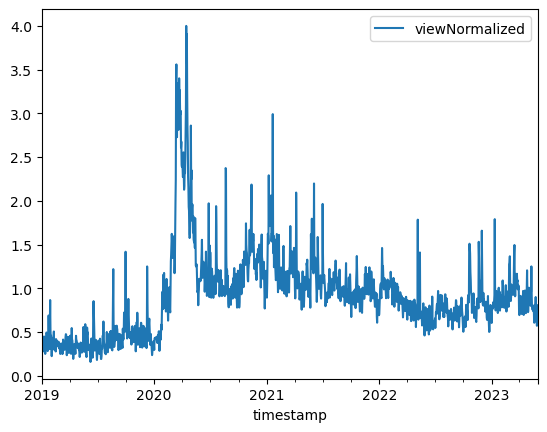

In [342]:
getViewsNormalizedTotal(topic, minMax).plot()

In [401]:
topic = wikiTopic(df_fakecovidNews, 1)

['Israeli_secret_service', 'The_Washington_Times', 'Biosafety_level_4', 'Wuhan_Institute_of_Virology', 'Li-Meng_Yan', 'Preprint', 'Steve_Bannon', 'Guo_Wengui', 'Expatriate', 'Anti-Chinese_sentiment', 'Echo_chamber_(media)', 'Plandemic', 'The_Epoch_Times', 'Chinese_Communist_Party', 'Falun_Gong', 'Misinformation_related_to_the_COVID-19_pandemic#Misinformation_regarding_virus_origin', 'Severe_acute_respiratory_syndrome_coronavirus_2', 'Chinese_Communist_Party', 'Fort_Detrick', 'Andrew_Bridgen']
Error fetching data for Misinformation_related_to_the_COVID-19_pandemic#Misinformation_regarding_virus_origin. Status Code: 404


In [444]:
topic = wikiTopic(df_fakecovidNews, 2)

['Gain-of-function_research', 'Angela_Rasmussen', 'Tucker_Carlson', 'Nicholas_Wade', 'Rand_Paul', 'Ralph_Baric', 'Francis_Collins', 'Chimeric_virus']
['Gain-of-function_research', 'Angela_Rasmussen', 'Tucker_Carlson', 'Nicholas_Wade', 'Rand_Paul', 'Ralph_Baric', 'Francis_Collins', 'Chimeric_virus']
Gain-of-function_research
[]
Angela_Rasmussen
[          project                    article granularity  timestamp  \
0    en.wikipedia  Gain-of-function_research       daily 2021-01-16   
1    en.wikipedia  Gain-of-function_research       daily 2021-01-17   
2    en.wikipedia  Gain-of-function_research       daily 2021-01-18   
3    en.wikipedia  Gain-of-function_research       daily 2021-01-19   
4    en.wikipedia  Gain-of-function_research       daily 2021-01-20   
..            ...                        ...         ...        ...   
859  en.wikipedia  Gain-of-function_research       daily 2023-05-27   
860  en.wikipedia  Gain-of-function_research       daily 2023-05-28   
861  en.wikipe

In [446]:
print(topic.df["Sub-subheading"])

getInfoByArticles(topic.dfView)

Gain-of-function research


,mean,median,std
article,,,
Angela_Rasmussen,42.408304,29.0,57.701045
Chimeric_virus,0.72402,1.0,0.917493
Francis_Collins,605.313896,442.5,690.336084
Gain-of-function_research,634.116898,315.0,1236.438714
Nicholas_Wade,117.177419,43.0,477.985603
Ralph_Baric,2.92375,2.0,2.885454
Rand_Paul,3454.568238,1842.5,7677.207855
Tucker_Carlson,7737.588089,5080.5,15570.257244


In [447]:
topic = wikiTopic(df_fakecovidNews, 3)

['Tedros_Adhanom_Ghebreyesus', 'Science_(journal)']
['Tedros_Adhanom_Ghebreyesus', 'Science_(journal)']
Tedros_Adhanom_Ghebreyesus
[          project                    article granularity  timestamp  \
0    en.wikipedia  Gain-of-function_research       daily 2021-01-16   
1    en.wikipedia  Gain-of-function_research       daily 2021-01-17   
2    en.wikipedia  Gain-of-function_research       daily 2021-01-18   
3    en.wikipedia  Gain-of-function_research       daily 2021-01-19   
4    en.wikipedia  Gain-of-function_research       daily 2021-01-20   
..            ...                        ...         ...        ...   
859  en.wikipedia  Gain-of-function_research       daily 2023-05-27   
860  en.wikipedia  Gain-of-function_research       daily 2023-05-28   
861  en.wikipedia  Gain-of-function_research       daily 2023-05-29   
862  en.wikipedia  Gain-of-function_research       daily 2023-05-30   
863  en.wikipedia  Gain-of-function_research       daily 2023-05-31   

         access

In [436]:
print(topic.df["Sub-subheading"])

getInfoByArticles(topic.dfView)

Accidental release of collected sample


,mean,median,std
article,,,
Science_(journal),409.287221,375.5,151.077270
Tedros_Adhanom_Ghebreyesus,268.77095,42.0,487.574544
